# Benchmarking

This notebook benchmarks 4 algorithms on a ASC dataset for constrained neural networks training and is divided as follows: 

1. SSL-ALM
2. Switching Subgradient 
3. [Cooper](https://github.com/cooper-org/cooper?tab=readme-ov-file)
4. [CHOP](https://github.com/openopt/chop)

-------------------------------------------------------------------------



In [24]:
# define the torch seed here
seed_n = 1
n_epochs = 30

# log path file
log_path = "./data/logs/log_benchmark.npz"

# Deterministic constraints: 

#### 1. Unconstrainted Optimization

Mainly for setting a reference bar

In [2]:
# load and prepare data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from folktables import ACSDataSource, ACSIncome, generate_categories

# load folktables data
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["VA"], download=True)
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncome.features, definition_df=definition_df)
df_feat, df_labels, _ = ACSIncome.df_to_pandas(acs_data,categories=categories, dummies=True)

In [3]:
sens_cols = ['SEX_Female', 'SEX_Male']
features = df_feat.drop(columns=sens_cols).to_numpy(dtype="float")
groups = df_feat[sens_cols].to_numpy(dtype="float")
labels = df_labels.to_numpy(dtype="float")

print(sens_cols)
print(features.shape)
print(groups.shape)
print(labels.shape)

['SEX_Female', 'SEX_Male']
(46144, 800)
(46144, 2)
(46144, 1)


In [4]:
# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    features, labels, groups, test_size=0.2, random_state=42)

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# make into a pytorch dataset, remove the sensitive attribute
features_train = torch.tensor(X_train, dtype=torch.float32)
labels_train = torch.tensor(y_train,dtype=torch.float32)
sens_train = torch.tensor(groups_train)
dataset_train = torch.utils.data.TensorDataset(features_train, labels_train)

In [7]:
import torch
from torch.nn import Sequential

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001,
)

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [9]:
# alloc arrays for plotting
Adam_loss_log_plotting = []
Adam_c_log_plotting    = []

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays
    loss_log = []
    c_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        
        # calculate constraints - just for logging since this is an unconstrainted optimization
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )   

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        
        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()
    
    # save the epoch values for plotting
    Adam_loss_log_plotting.append(np.mean(loss_log))
    Adam_c_log_plotting.append(np.mean(c_log, axis=0))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.43511515855789185, constraints: [6.6764483  0.38848972 1.722991   0.504136   0.6301912  0.12649561], 
Epoch: 1, loss: 0.3954301178455353, constraints: [8.44853    0.51563394 2.1661036  0.5607829  0.5494498  0.10689577], 
Epoch: 2, loss: 0.38201919198036194, constraints: [9.634612   0.64335984 2.5231967  0.61415195 0.53373504 0.10923984], 
Epoch: 3, loss: 0.36854541301727295, constraints: [10.813012    0.88398665  2.8339233   0.7209996   0.56822145  0.10879268], 
Epoch: 4, loss: 0.3551674485206604, constraints: [12.035949    1.1691632   3.102864    0.8447036   0.6508932   0.11913007], 
Epoch: 5, loss: 0.3405885100364685, constraints: [13.329719    1.5084465   3.3776112   0.9940546   0.7493791   0.11347131], 
Epoch: 6, loss: 0.3248720169067383, constraints: [15.17101     1.8669537   3.6588163   1.145411    0.8923904   0.11733691], 
Epoch: 7, loss: 0.3085455596446991, constraints: [16.919092    2.198779    4.016772    1.2334425   1.0460272   0.12670039], 
Epoch: 8, loss:

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# load the plotting function
def plot_losses_and_constraints(
    losses_list,
    constraints_list,
    constraint_thresholds,
    titles=None,
    plot_individual_constraints=True,
):
    """
    Plot loss and constraint values for multiple ML algorithms.

    Parameters
    ----------
    losses_list : list of np.ndarray
        Each element is a 1D array of loss values for one algorithm.
    constraints_list : list of list of np.ndarray
        Each element is a list of 1D arrays (constraint values for that algorithm).
    constraint_thresholds : np.ndarray or list
        One or more threshold values to plot as dashed lines (same for all algos).
    titles : list of str, optional
        Column titles (algorithm names).
    plot_individual_constraints : bool, optional (default=True)
        If True, plots all individual constraint curves.
    """
    num_algos = len(losses_list)
    if titles is None:
        titles = [f"Algorithm {i+1}" for i in range(num_algos)]
    constraint_thresholds = np.atleast_1d(constraint_thresholds)

    fig, axes = plt.subplots(2, num_algos, figsize=(5*num_algos, 8), sharex='col')
    if num_algos == 1:
        axes = np.array([[axes[0]], [axes[1]]])  # ensure consistent 2D indexing

    for j in range(num_algos):
        loss = np.asarray(losses_list[j])
        x = np.arange(len(loss))

        # --- Loss plot ---
        ax_loss = axes[0, j]
        ax_loss.plot(x, loss, color='tab:blue', label='Loss')
        ax_loss.set_title(titles[j])
        ax_loss.set_ylabel('Mean Loss')
        # ax_loss.grid(True, linestyle='--', alpha=0.4)
        # ax_loss.legend()

        # --- Constraints plot ---
        constraints = np.array(constraints_list[j])  # shape (num_constraints, timesteps)
        c_min = np.min(constraints, axis=0)
        c_max = np.max(constraints, axis=0)

        ax_constr = axes[1, j]
        # Optional: individual constraints
        if plot_individual_constraints:
            for c in constraints:
                ax_constr.plot(x, c, color='tab:orange', alpha=0.4, linewidth=1)

        # Shaded band (min–max)
        ax_constr.fill_between(x, c_min, c_max, color='tab:orange', alpha=0.3, label='Constraint range')

        # Threshold line(s)
        for th in constraint_thresholds:
            ax_constr.axhline(th, color='tab:red', linestyle='--', linewidth=1, label='Threshold')

        ax_constr.set_ylabel('Mean Constraint values')
        # ax_constr.grid(True, linestyle='--', alpha=0.4)
        # ax_constr.legend()

    axes[-1, 0].set_xlabel('Epoch')
    plt.tight_layout()
    plt.show()


In [ ]:
# save the computed data
np.savez(log_path, losses=[np.array(Adam_loss_log_plotting)], constraints=[np.array(Adam_c_log_plotting).T])


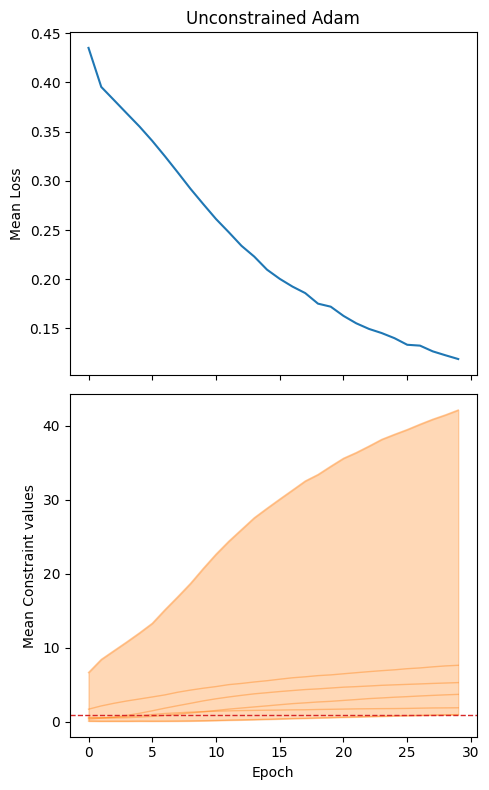

In [ ]:
# 4 algorithms, each with a 1D loss array and 2 constraints
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints(losses, constraints, thresholds, titles=['Unconstrained Adam'], plot_individual_constraints=True)

#### 2.1 SSL-ALM SGD

In [12]:
from humancompatible.train.algorithms import SSLALM

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSLALM(
    params=model.parameters(),
    m=m,
    lr=0.01,
    dual_lr=0.1
)

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [13]:
# alloc arrays for plotting
SSL_ALM_loss_log_plotting = []
SSL_ALM_c_log_plotting    = []

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        
        # calculate constraints and constraint grads - constraint per each weight matrix
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )   

            # calculate the Jacobian of the constraint
            norm_viol.backward()

            # update the dual variable + save the Jacobian for later - its needed in the primal variable update
            optimizer.dual_step(i, c_val=norm_viol)
            optimizer.zero_grad()

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())
        
        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())
        
        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()
    
    # save the epoch values for plotting
    SSL_ALM_loss_log_plotting.append(np.mean(loss_log))
    SSL_ALM_c_log_plotting.append(np.mean(c_log, axis=0))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.5579718947410583, constraints: [0.91289365 0.24924642 0.98641264 0.46461216 0.8706531  0.0809375 ], dual: [0.15808122 0.         0.15734595 0.         0.18665232 0.        ]
Epoch: 1, loss: 0.4504135251045227, constraints: [0.99983734 0.6695479  0.9999918  0.620562   0.99979573 0.1346861 ], dual: [0.20943607 0.         0.24302068 0.         0.26294106 0.        ]
Epoch: 2, loss: 0.4304848611354828, constraints: [0.9995153  0.9619843  0.9994795  0.6824137  0.99937683 0.12399884], dual: [0.24753165 0.024619   0.29907224 0.         0.31656897 0.        ]
Epoch: 3, loss: 0.42205721139907837, constraints: [0.9992969  0.9999009  0.99915123 0.7147378  0.9990516  0.11551728], dual: [0.2759154  0.03314717 0.34108055 0.         0.35924911 0.        ]
Epoch: 4, loss: 0.415507972240448, constraints: [0.9992796  0.9998441  0.99893236 0.7371917  0.9988579  0.11083457], dual: [0.30049405 0.0384515  0.37884513 0.         0.39508054 0.        ]
Epoch: 5, loss: 0.4103803336620331, cons

In [25]:
# save the computed data
np.savez(log_path, losses=[np.array(Adam_loss_log_plotting), np.array(SSL_ALM_loss_log_plotting)], constraints=[np.array(Adam_c_log_plotting).T, np.array(SSL_ALM_c_log_plotting).T])

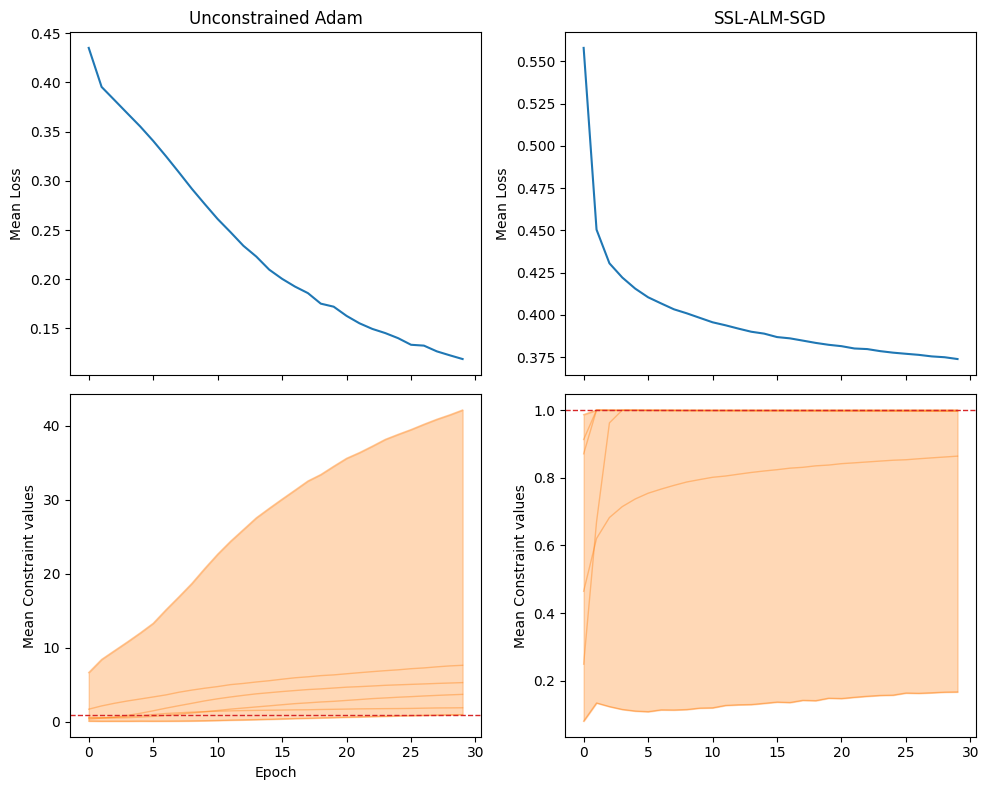

In [26]:
# 4 algorithms, each with a 1D loss array and 2 constraints
losses = np.load(log_path)["losses"]
constraints = np.load(log_path)["constraints"]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints(losses, constraints, thresholds, titles=['Unconstrained Adam', 'SSL-ALM-SGD'], plot_individual_constraints=True)


#### 2.2 SSL-ALM Adam

In [15]:
import sys, os
# Add the ../src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.humancompatible.train.optim.ssl_alm_adam import SSLALM_Adam

# set the same seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSLALM_Adam(
    params=model.parameters(),
    m=m,
    lr=0.001,
    dual_lr=0.1
)

# bounds for the constraints: norm of each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# alloc arrays for plotting
SSL_ALM_Adam_loss_log_plotting = []
SSL_ALM_Adam_c_log_plotting    = []

# training loop
for epoch in range(n_epochs):
    
    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []

    # go through all data
    for batch_input, batch_label in dataloader:
        
        # calculate constraints and constraint grads - constraint per each weight matrix
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[i],
                torch.zeros(1)
            )   

            # calculate the Jacobian of the constraint
            norm_viol.backward()

            # update the dual variable + save the Jacobian for later - its needed in the primal variable update
            optimizer.dual_step(i, c_val=norm_viol[0])
            optimizer.zero_grad()

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())
        
        # calculate loss and grad
        batch_output = model(batch_input)
        loss = criterion(batch_output, batch_label)
        loss.backward()

        # save the loss and the dual variables
        loss_log.append(loss.detach().numpy())
        duals_log.append(optimizer._dual_vars.detach())
        
        # update the primal variables together with smoothing dual variable
        optimizer.step()
        optimizer.zero_grad()
    
    # save the epoch values for plotting
    SSL_ALM_Adam_loss_log_plotting.append(np.mean(loss_log))
    SSL_ALM_Adam_c_log_plotting.append(np.mean(c_log, axis=0))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}"
    )

Epoch: 0, loss: 0.4723862409591675, constraints: [0.99252886 0.8578229  0.9957494  0.5817967  0.97313005 0.11155563], dual: [0.22677718 0.03142228 0.2712402  0.         0.1829153  0.        ]
Epoch: 1, loss: 0.4329614043235779, constraints: [0.9998062  0.9987647  0.99458426 0.6766139  0.9987317  0.10273167], dual: [0.2952882  0.03979757 0.33099392 0.         0.21134071 0.        ]
Epoch: 2, loss: 0.42496538162231445, constraints: [0.9995622  0.99908066 0.9947571  0.7374871  0.99866813 0.09922082], dual: [0.35571742 0.04351856 0.37677    0.         0.23427597 0.        ]
Epoch: 3, loss: 0.42015278339385986, constraints: [0.999351   0.9989684  0.99527013 0.7910233  0.9989827  0.09637725], dual: [0.4118644  0.04673047 0.41410798 0.         0.25330257 0.        ]
Epoch: 4, loss: 0.41484254598617554, constraints: [0.99914044 0.9991269  0.99500895 0.8437214  0.99897933 0.09624666], dual: [0.4644329  0.04905657 0.44591925 0.         0.2696333  0.        ]
Epoch: 5, loss: 0.41130131483078003, 

In [ ]:
# 4 algorithms, each with a 1D loss array and 2 constraints
losses = [ np.array(Adam_loss_log_plotting), np.array(SSL_ALM_loss_log_plotting), np.array(SSL_ALM_Adam_c_log_plotting) ]
constraints = [ np.array(Adam_c_log_plotting).T, np.array(SSL_ALM_c_log_plotting).T , np.array(SSL_ALM_Adam_c_log_plotting).T ]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints(losses, constraints, thresholds, titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam'], plot_individual_constraints=True)

NameError: name 'SSL_ALM_loss_log_plotting' is not defined

#### 3. Switching-Subgradient

In [ ]:
from humancompatible.train.algorithms import SSG

# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# create the SSLALM optimizer
optimizer = SSG(
    params=model.parameters(),
    m=1,
    lr=0.01,
    dual_lr=0.1
)

# bounds for the constraints: norm of max each weight matrix should be <= 1
constraint_bounds = [1.]

# define epochs + loss function - same loss should be defined for all algorithms
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# alloc the plotting array
SSG_c_log_plotting = []
SSG_loss_log_plotting = []

# training loop
for epoch in range(n_epochs):
    
    # alloc logging array
    loss_log = []
    c_log = []
    duals_log = []

    # train for all data
    for batch_input, batch_label in dataloader:
        
        # prepare the max of the violation
        max_norm_viol = torch.zeros(1)
        c_log.append([])
        
        # calculate constraints and constraint grads - max of constraint per each weight matrix
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # convert constraint to equality
            norm_viol = torch.max(
                norm 
                - constraint_bounds[0],
                torch.zeros(1)
            )   

            # save the max 
            max_norm_viol = torch.max(max_norm_viol, norm_viol)

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # calculate the Jacobian of the max-violating norm constraint
        max_norm_viol.backward()

        # save the gradient of the constraint
        optimizer.dual_step(0)
        optimizer.zero_grad()

        # calculate loss and grad
        out = model(batch_input)
        loss = criterion(out, batch_label)
        loss.backward()
        
        # save the loss value
        loss_log.append(loss.detach().numpy())
        
        # perform a step - either update based on the loss grad or constraint grad
        optimizer.step(max_norm_viol)
        optimizer.zero_grad()
        
    # save the epoch values for plotting
    SSG_loss_log_plotting.append(np.mean(loss_log))
    SSG_c_log_plotting.append(np.mean(c_log, axis=0))
    
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
    )

Epoch: 0, loss: 0.5636869072914124, constraints: [0.8865569  0.2551967  0.9572769  0.46421272 0.8471299  0.07630552], 
Epoch: 1, loss: 0.4628611207008362, constraints: [0.9514828  0.6902075  0.967227   0.61517787 0.95142245 0.12884726], 
Epoch: 2, loss: 0.4419809579849243, constraints: [0.95245636 0.9431201  0.9661805  0.67615    0.9523784  0.12224942], 
Epoch: 3, loss: 0.43266552686691284, constraints: [0.96838695 0.9559374  0.9640981  0.71008044 0.95307636 0.11462068], 
Epoch: 4, loss: 0.42572417855262756, constraints: [0.96794224 0.9495907  0.9647045  0.73499    0.9521954  0.10768438], 
Epoch: 5, loss: 0.4200306534767151, constraints: [0.9737459  0.9542855  0.96672106 0.7538966  0.9529736  0.10590638], 
Epoch: 6, loss: 0.41630467772483826, constraints: [0.9797309  0.9470746  0.96606255 0.7677217  0.95301396 0.10679292], 
Epoch: 7, loss: 0.41277119517326355, constraints: [0.97991216 0.9549681  0.9622258  0.78073645 0.95376104 0.10501108], 
Epoch: 8, loss: 0.41035348176956177, constra

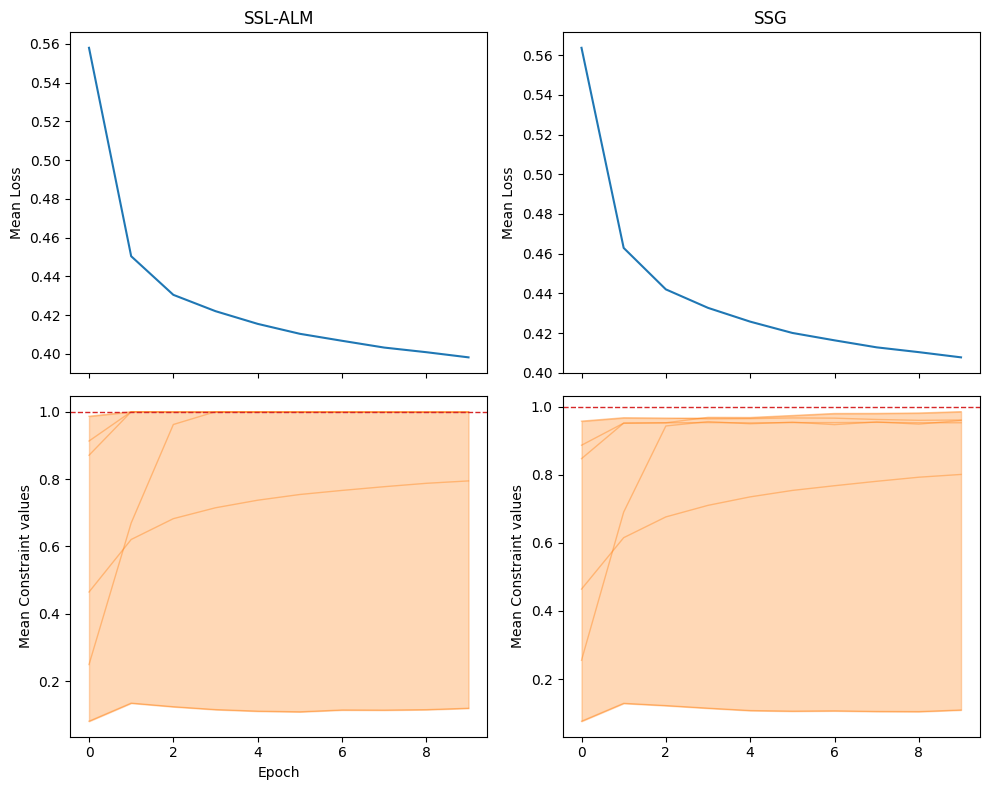

In [ ]:
# 4 algorithms, each with a 1D loss array and 2 constraints
losses = [ np.array(Adam_loss_log_plotting), np.array(SSL_ALM_loss_log_plotting), np.array(SSL_ALM_Adam_c_log_plotting), np.array(SSG_loss_log_plotting) ]
constraints = [ np.array(Adam_c_log_plotting).T, np.array(SSL_ALM_c_log_plotting).T , np.array(SSL_ALM_Adam_c_log_plotting).T, np.array(SSG_c_log_plotting).T ]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints(losses, constraints, thresholds, titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', 'SSG'], plot_individual_constraints=True)

#### 4. Cooper - Augmented Lagrangian

In [ ]:
# set the seed for fair comparisons
torch.manual_seed(seed_n)

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

# create small FC network - same as the other algorithms
latent_size1 = 64
latent_size2 = 32
model = Sequential(
    torch.nn.Linear(features_train.shape[1], latent_size1),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size1, latent_size2),
    torch.nn.ReLU(),
    torch.nn.Linear(latent_size2, 1)
)

# get number of layers + number of biases
m = len(list(model.parameters()))

# bounds for the constraints: norm of max each weight matrix should be <= 1
constraint_bounds = [1.]*m

# define epochs + loss function - same loss should be defined for all algorithms
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
import cooper

# select device
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cpu"

# define the problem
class ACS_Deterministic_Constr_Fair_ALM(cooper.ConstrainedMinimizationProblem):
    def __init__(self, formulation_type):
        super().__init__()


        # define the number of multipliers - same as the number of constraints
        if not formulation_type.expects_multiplier:
            self.multiplier = None
        else:
            self.multiplier = cooper.multipliers.DenseMultiplier(num_constraints=len(list(model.parameters())), device=DEVICE) 

        # add the penalty coefficient - augmented lagrangian
        if not formulation_type.expects_penalty_coefficient:
            self.penalty = None
        else:
            self.penalty = cooper.penalty_coefficients.DensePenaltyCoefficient(
                init=torch.tensor(1.0, device=DEVICE),
            )
        
        # inequality constraints on the norm of the matrix
        self.constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.INEQUALITY,
            formulation_type=formulation_type,
            multiplier=self.multiplier,
            penalty_coefficient=self.penalty,
        )


    # function that computes the constraints and the loss function
    def compute_cmp_state(self, model, inputs, targets):

        # compute the yhat loss
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        loss = criterion( model(inputs) , targets )

        # calculate constraints
        norm_values_c = []
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # compute the violation of the constraint
            norm_viol = norm - constraint_bounds[i] 
            norm_values_c.append(norm_viol)
        
        # compute the constraint violation
        constraint_state = cooper.ConstraintState(violation=torch.stack(norm_values_c))
        observed_constraints = {self.constraint: constraint_state}

        return cooper.CMPState(loss=loss, observed_constraints=observed_constraints)


In [ ]:
# create the problem
problem = ACS_Deterministic_Constr_Fair_ALM(cooper.formulations.AugmentedLagrangian)

# flag of dual variables
has_dual_variables = problem.multiplier is not None

# create the primal optimizer
primal_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create the dual optimizer
if has_dual_variables:
    dual_optimizer = torch.optim.SGD(problem.dual_parameters(), lr=0.1, maximize=True)

    # combine the optimizers
    constrained_optimizer = cooper.optim.SimultaneousOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
        dual_optimizers=dual_optimizer,
    )
else:
    # Formulations without dual variables, such as the Quadratic Penalty
    # formulation, do not require a dual optimizer
    constrained_optimizer = cooper.optim.UnconstrainedOptimizer(
        cmp=problem,
        primal_optimizers=primal_optimizer,
    )

# Increase the penalty coefficient by `increment` if the constraint is violate by more
# than `violation_tolerance`- keep this the same - since its not included in SSL-ALM implementation
penalty_scheduler = cooper.penalty_coefficients.AdditivePenaltyCoefficientUpdater(
    increment=0.0, 
    violation_tolerance=1e-3,
)

In [ ]:
# alloc arrays for plotting
Cooper_c_log_plotting    = []
Cooper_loss_log_plotting = []

# training loop
for epoch in range(n_epochs):

    # alloc the logging arrays
    loss_log = []
    c_log = []
    duals_log = []
    penalty_coefficient_values = []

    # alloc norm values array
    norm_values_c = []

    # go through all data
    for batch_input, batch_label in dataloader:

        # calculate constraints - just for logging
        c_log.append([])
        for i, param in enumerate(model.parameters()):

            # norm of the w. matrix
            norm = torch.linalg.norm(param, ord=2)

            # save the value of the constraint
            c_log[-1].append(norm.detach().numpy())

        # compute the loss - just for logging purposes
        loss = criterion( model(batch_input) , batch_label )
        loss_log.append(loss.item())

        # compute the states
        compute_cmp_state_kwargs = {"model": model, "inputs": batch_input, "targets": batch_label}
        roll_out = constrained_optimizer.roll(compute_cmp_state_kwargs=compute_cmp_state_kwargs)

        # Update the penalty coefficient
        constraint_state = roll_out.cmp_state.observed_constraints[problem.constraint]
        penalty_scheduler.update_penalty_coefficient_(problem.constraint, constraint_state)

        # get the dual variables and the coefficients
        multiplier_value = problem.multiplier.weight.detach().numpy() if has_dual_variables else None
        penalty_coefficient_value = problem.constraint.penalty_coefficient().item()

        # save the duals and penalty coefficients
        duals_log.append(multiplier_value)
        penalty_coefficient_values.append(penalty_coefficient_value)

    # save the epoch values for plotting
    Cooper_loss_log_plotting.append(np.mean(loss_log))
    Cooper_c_log_plotting.append(np.mean(c_log, axis=0))

    # print out the epoch values
    print(
        f"Epoch: {epoch}, "
        f"loss: {np.mean(loss_log)}, "
        f"constraints: {np.mean(c_log, axis=0)}, "
        f"dual: {np.mean(duals_log, axis=0)}, "
        f"penalty coefficients: {np.mean(penalty_coefficient_values, axis=0)}, "
    )
    
    # TODO:  ssl-alm adam try out
    

Epoch: 0, loss: 0.4694080853599093, constraints: [0.99977535 0.8927813  0.9987209  0.56353205 0.9767968  0.11757322], dual: [ 0.12802611 -0.00722992  0.04998935 -0.04362014  0.03313114 -0.08820604], penalty coefficients: 1.0, 
Epoch: 1, loss: 0.44417348637066434, constraints: [1.0000086  0.99931973 0.99949604 0.70522237 0.99947864 0.10355154], dual: [ 0.14721684  0.00708862  0.05724068 -0.02946182  0.04814353 -0.08960644], penalty coefficients: 1.0, 
Epoch: 2, loss: 0.4364263997050051, constraints: [0.99985147 0.9990649  0.9996338  0.86919904 0.99936914 0.09342793], dual: [ 0.14683396  0.00689173  0.05955346 -0.01307087  0.05227868 -0.09061798], penalty coefficients: 1.0, 
Epoch: 3, loss: 0.43257614246454973, constraints: [1.0000596  0.9993597  1.0000476  0.9840256  0.9996412  0.08345351], dual: [ 0.14557114  0.00726979  0.06181119 -0.00132039  0.05504715 -0.09161504], penalty coefficients: 1.0, 
Epoch: 4, loss: 0.4285752162001575, constraints: [1.0001726  0.9992785  0.9999631  0.99060

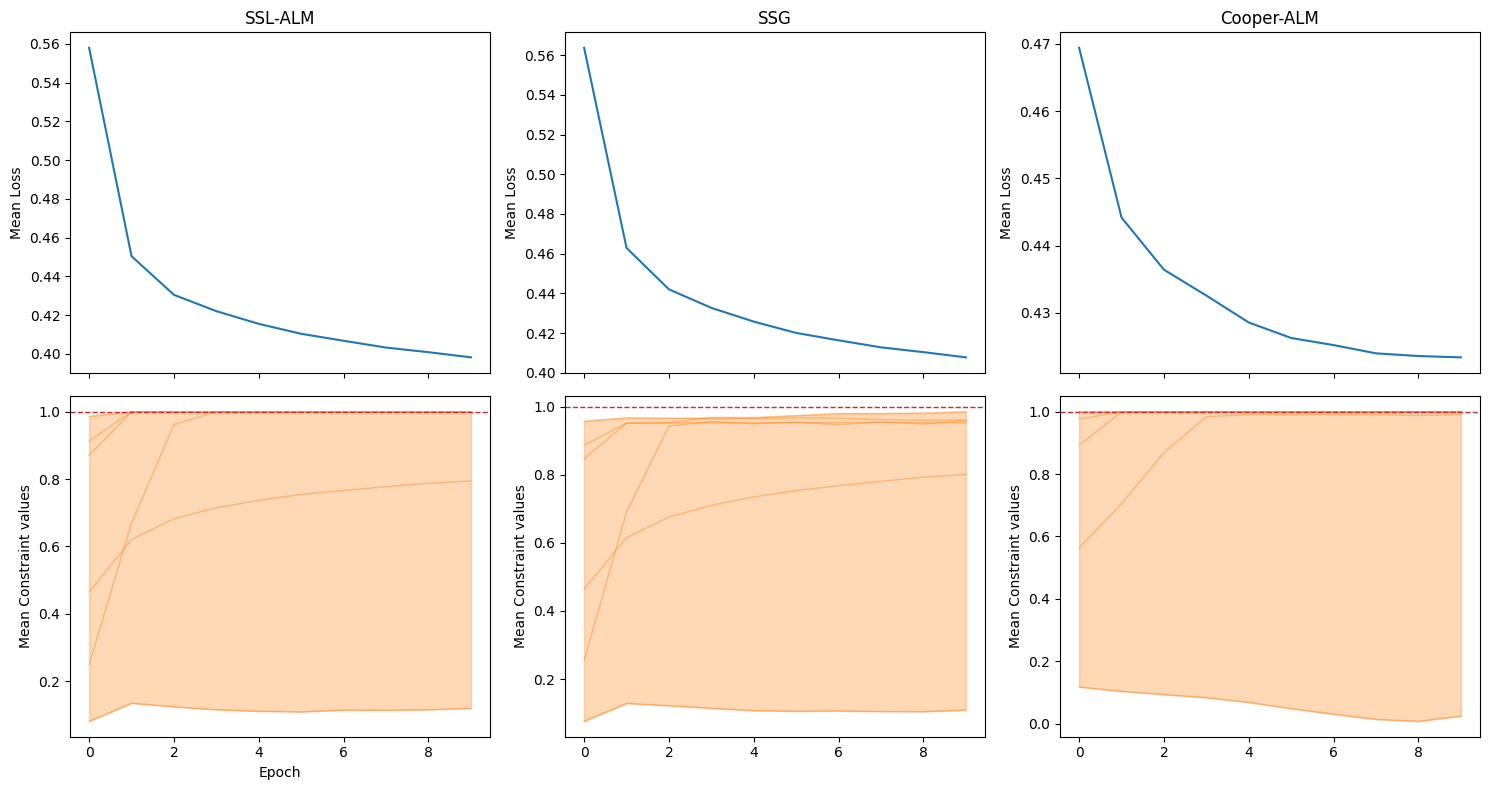

In [ ]:
# 4 algorithms, each with a 1D loss array and 2 constraints

losses = [ np.array(Adam_loss_log_plotting), np.array(SSL_ALM_loss_log_plotting), np.array(SSL_ALM_Adam_c_log_plotting), np.array(SSG_loss_log_plotting) , np.array(Cooper_loss_log_plotting)]
constraints = [ np.array(Adam_c_log_plotting).T , np.array(SSL_ALM_c_log_plotting).T , np.array(SSL_ALM_Adam_c_log_plotting).T, np.array(SSG_c_log_plotting).T , np.array(Cooper_c_log_plotting).T]
thresholds = [ constraint_bounds[0] ]

plot_losses_and_constraints(losses, constraints, thresholds, titles=['Unconstrained Adam', 'SSL-ALM-SGD', 'SSL-ALM-Adam', 'SSG', 'Cooper-ALM'], plot_individual_constraints=True)

